# Kickstarter Project - EDA

![image-asset.jpeg](image-asset.jpeg)

## Intro

Kickstarter is an American public benefit corporation based in New York, that maintains a global crowdfunding platform focused on creativity.
The company's stated mission is to "help bring creative projects to life". As of December 2019, Kickstarter has received more than $4.6 billion in pledges from 17.2 million backers to fund 445,000 projects, such as films, music, stage shows, comics, journalism, video games, technology, publishing, and food-related projects.

People who back Kickstarter projects are offered tangible rewards or experiences in exchange for their pledges. This model traces its roots to subscription model of arts patronage, where artists would go directly to their audiences to fund their work.


This dataset includes kickstarter data from 2009 - 2019 with over 200.000 projects and 37 attributes.

Target of this project: Making correct prediction if campaign will be sucessful or not by use of three different machine learning algorithms. A campaign is successful when the collected amount (=pledged) is the same or greater than the requested amount (=goal).

Questions:
* Which features are important for a successful campaign?
* What kind of campaigns can be recommended to backers?
* What can be helpful for creator to make a campaign successful?
* Requested Money for Campaign (Goal) relevant for success?

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

RSEED=42

## The Dataset

In [2]:
df = pd.read_csv('data/df_clean.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df[(df['state']=='failed') | (df['state']=='successful')]

After bringing together all the data sets and dropping the dublicates, a first look revealed a dataset with:
* features with missing values (friends, is_backing, is_starred and permissions)
* pointless features (currency_symbol, current_currency, id, photo and urls)
* pointless feature spotlight: attention to products and history after the project succeeded
* 5 categories of state: successful, failed, canceled, live and suspended

Above named features are dropped and since we are interested in the successful/failed state, the other categories can be dropped, too. 10% of the data is kept as the test set and will be used at the end. For further analysis the actual dataset consists of 151,867 rows with 29 features and is stored as csv-file.

## Cleaning Preparation

In [3]:
def prepForModel(df):
    drop_cols = [
        'blurb',
        'creator',
        'currency',
        'currency_trailing_code',
        'location',
        'name',
        'profile',
        'slug',
        'source_url',
        'static_usd_rate',
        'usd_type'
    ]
    df.drop(drop_cols, inplace=True, axis = 1)
    for c in df.columns: 
        if df[c].dtype == "object": 
            df[c] = df[c].astype("category") 
    df.dropna(inplace=True)
    return df

df = prepForModel(df)

## Features

Most meaningful attributes/features to analyse are:

* backers_count: amount/number of different investors
* converted_pledged_amount: Amounts paid to creator (project owner)
* country: country of origin of the project
* created_at: time the project was created at Kickstarter (UNIX Timestamp in seconds since 1970)
* creator: creator of kickstarter campaign plus more subcategories
* deadline: time when project will end (UNIX Timestamp in seconds since 1970)
* disable_communication
* goal: target amount of money you want to get from backers
* is_starrable
* launched_at: time the project is launched (UNIX Timestamp in seconds since 1970)
* pledged: amount of money in local currency offered from investors 
* staff_pick: are positive voted by staff members of kickstart
* state: state of project development (successfull, failed), target feature
* state_changed_at: time the state has changed (UNIX Timestamp in seconds since 1970)
* usd_pledged: pledged amounts converted in USD
* category_name: subcategories regarding product
* category_slug: subcategories regarding product
* cgrouped: region of origin (instead of country)

## Target: Failed or Successful?

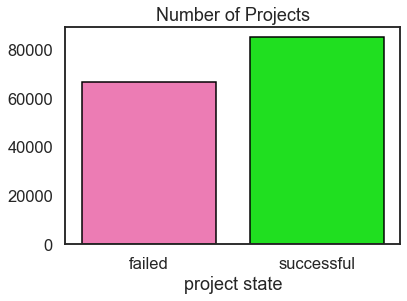

In [4]:
sns.set_style('white')
sns.set_context("talk")
sns.countplot(x=df.state,
              palette={"failed": "hotpink", "successful": "lime"},
              edgecolor='black'
             ).set_title('Number of Projects')
plt.xlabel("project state")
plt.ylabel("")
plt.savefig('images/Number of Projects');

In [5]:
# Conversion of goal in local currencies to goal in USD:
df['Goal_USD'] = df['goal'] * df['fx_rate']

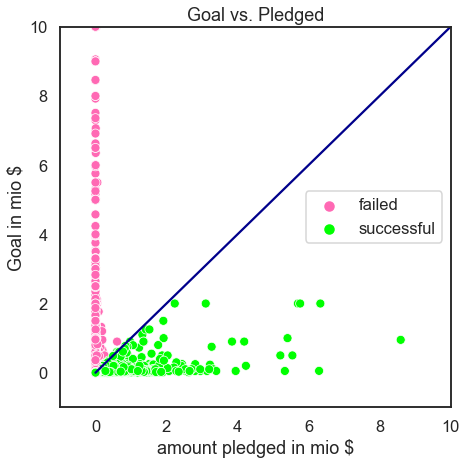

In [6]:
#overview of requested money and pledged amount:
#with changed ranges for both axis with a range from 0 to 10 Millions:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(
    x=df.usd_pledged/1e6, 
    y=df.Goal_USD/1e6, 
    hue=df.state, 
    palette={"failed": "hotpink", "successful": "lime"}
)
sns.lineplot(x=(0,50), y=(0,50), color='darkblue')
ax.set(ylim=(-1,10), xlim=(-1,10))
ax.set(xlabel='amount pledged in mio $', ylabel='Goal in mio $', title= 'Goal vs. Pledged')
plt.savefig('images/Goal vs. Pledged.png');

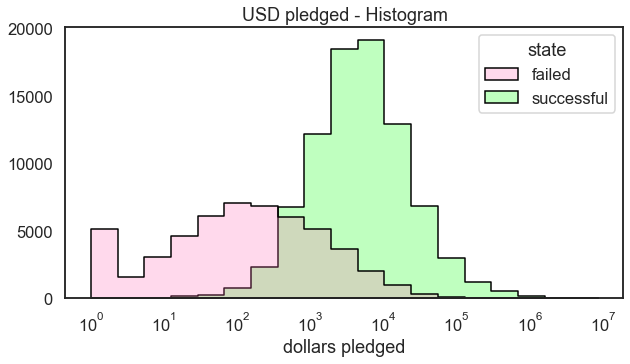

In [7]:
plt.figure(figsize=(10,5))
LogMin, LogMax = np.log10(df['usd_pledged'].min()+1.),np.log10(df['usd_pledged'].max())
newBins = np.logspace(LogMin, LogMax,20)
sns.histplot(
    data=df, 
    x='usd_pledged', 
    hue='state', 
    palette={"failed": "hotpink", "successful": "lime"},
    bins=newBins,
    edgecolor='black',
    element='step'
).set_title('USD pledged - Histogram')
plt.xscale('log')
plt.xlabel("dollars pledged")
plt.ylabel("")
plt.savefig('images/USD pledged - Histogram.png');

## Regional Influence

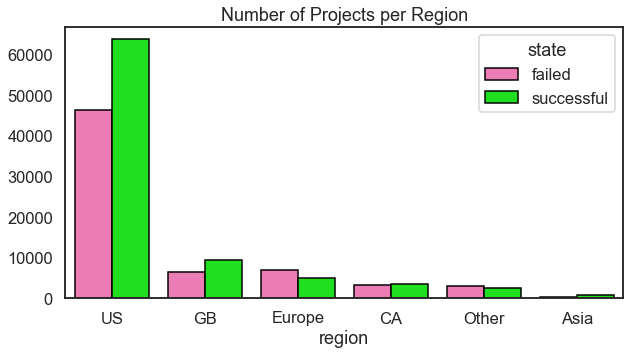

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(
    data=df,
    x="cgrouped",
    hue="state",
    palette={"failed": "hotpink", "successful": "lime"},
    order=df.cgrouped.value_counts().iloc[:6].index,
    edgecolor='black'
).set_title('Number of Projects per Region')
plt.xlabel("region")
plt.ylabel("")
plt.savefig('images/Number of Projects per Region.png');

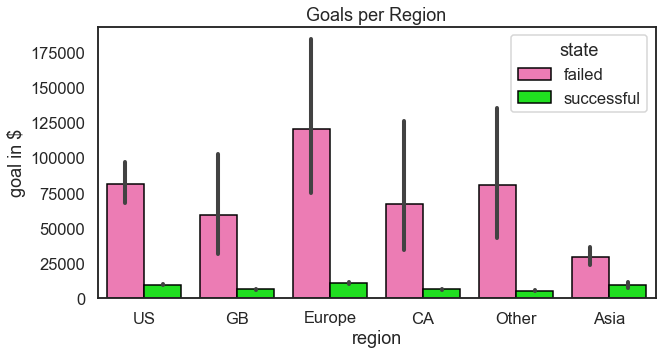

In [9]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=df,
    x="cgrouped",
    y='Goal_USD',
    hue="state",
    palette={"failed": "hotpink", "successful": "lime"},
    order=df.cgrouped.value_counts().iloc[:6].index,
    edgecolor='black'
).set_title('Goals per Region')
plt.xlabel("region")
plt.ylabel("goal in $")
plt.savefig('images/Goals per Region.png');

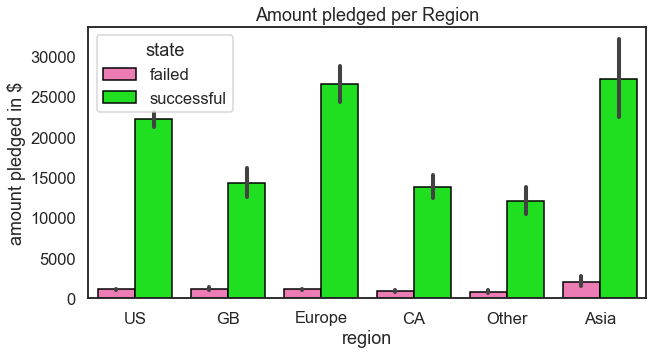

In [10]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=df,
    x="cgrouped",
    y='usd_pledged',
    hue="state",
    palette={"failed": "hotpink", "successful": "lime"},
    order=df.cgrouped.value_counts().iloc[:6].index,
    edgecolor='black'
).set_title('Amount pledged per Region')
plt.xlabel("region")
plt.ylabel("amount pledged in $")
plt.savefig('images/Amount pledged per Region.png');

## Kickstarter Development

In [11]:
df_y = pd.read_csv('data/df_clean.csv')
df_y.drop(df_y.columns[df_y.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_y = df_y[(df_y['state']=='failed') | (df_y['state']=='successful')]
df_y = prepForModel(df_y)
def toDateYear(time_delta):
    return (datetime.fromtimestamp(time_delta)).year
df_y.created_at=df_y.created_at.apply(toDateYear)
df_y['Goal_USD'] = df_y['goal'] * df_y['fx_rate']
df_y['delta_pledge_usdgoal'] = df_y['usd_pledged'] - df_y['Goal_USD']
df_y = df_y[(df_y['state']=='failed') | (df_y['state']=='successful')]

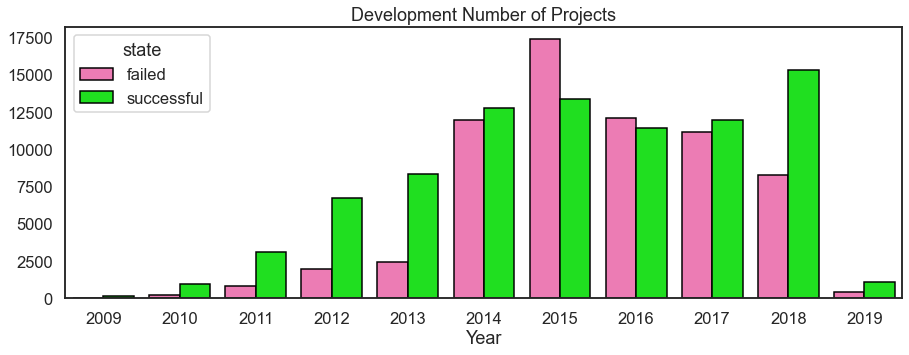

In [12]:
plt.figure(figsize=(15,5))
sns.countplot(
    data=df_y,
    x='created_at',
    hue='state',
    palette={"failed": "hotpink", "successful": "lime"},
    edgecolor='black'
).set_title('Development Number of Projects')
plt.xlabel("Year")
plt.ylabel("")
plt.savefig('images/Development Number of Projects.png');

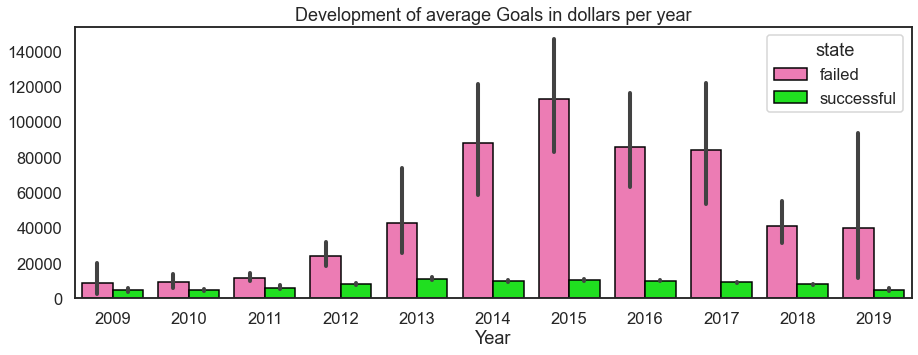

In [13]:
plt.figure(figsize=(15,5))
sns.barplot(
    data=df_y,
    x='created_at',
    y='Goal_USD',
    hue='state',
    palette={"failed": "hotpink", "successful": "lime"},
    edgecolor='black'
).set_title('Development of average Goals in dollars per year')
plt.xlabel("Year")
plt.ylabel("")
plt.savefig('images/Development of average Goals in dollars per year.png');

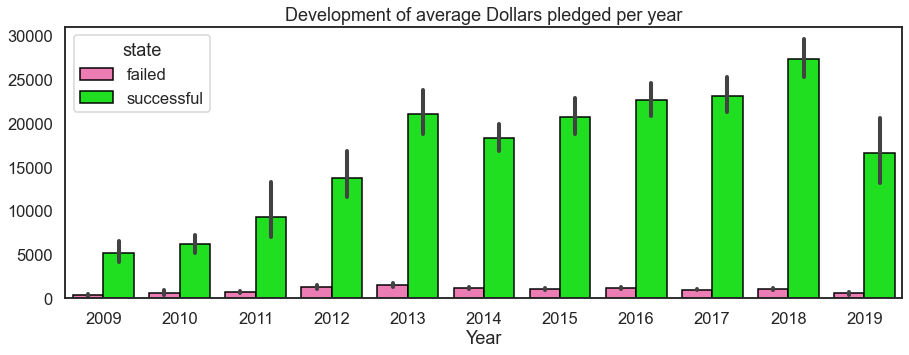

In [14]:
plt.figure(figsize=(15,5))
sns.barplot(
    data=df_y,
    x='created_at',
    y='usd_pledged',
    hue='state',
    palette={"failed": "hotpink", "successful": "lime"},
    edgecolor='black'
).set_title('Development of average Dollars pledged per year')
plt.xlabel("Year")
plt.ylabel("")
plt.savefig('images/Development of average Dollars pledged per year.png');

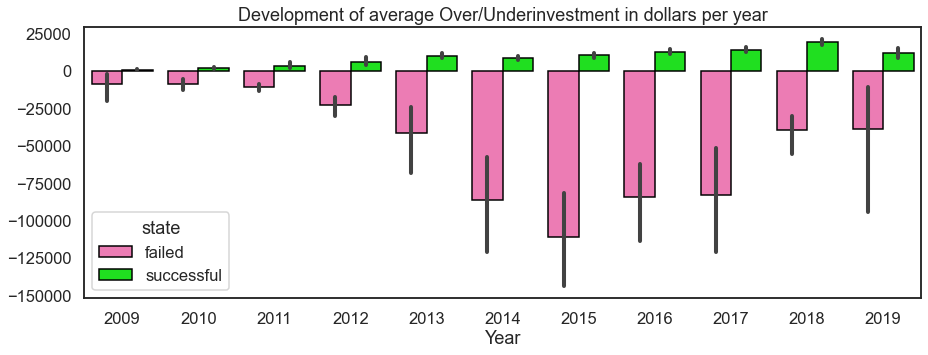

In [15]:
df['delta_pledge_usdgoal'] = df['usd_pledged'] - df['Goal_USD']
plt.figure(figsize=(15,5))
sns.barplot(
    data=df_y,
    x='created_at',
    y='delta_pledge_usdgoal',
    hue='state',
    palette={"failed": "hotpink", "successful": "lime"},
    edgecolor='black'
).set_title('Development of average Over/Underinvestment in dollars per year')
plt.xlabel("Year")
plt.ylabel("")
plt.savefig('images/Development of average Over-Underinvestment in dollars per year.png');

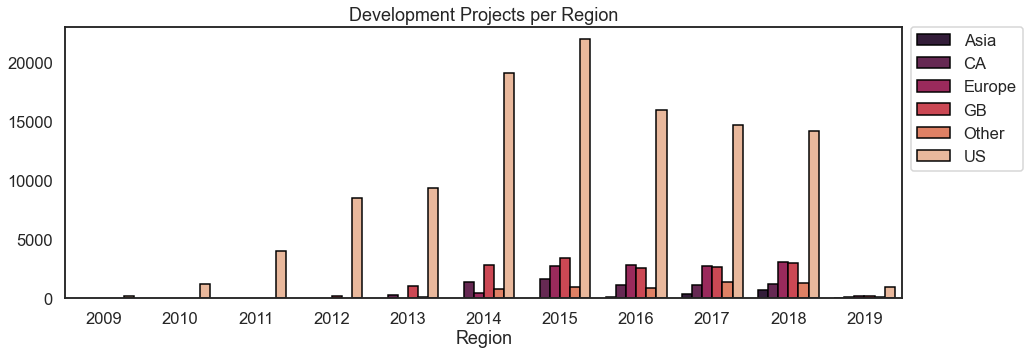

In [16]:
plt.figure(figsize=(15,5))
sns.countplot(
    data=df_y,
    x='created_at',
    hue='cgrouped',
    palette='rocket',
    edgecolor='black'
).set_title('Development Projects per Region')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.xlabel("Region")
plt.ylabel("")
plt.savefig('images/Development Projects per Region.png');

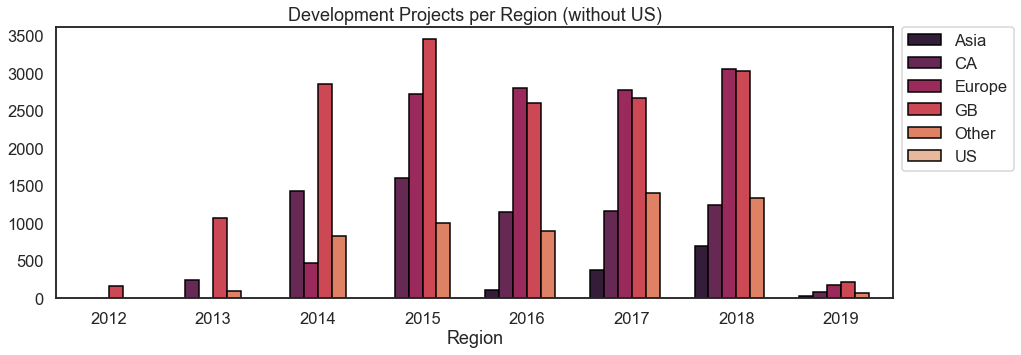

In [17]:
plt.figure(figsize=(15,5))
sns.countplot(
    data=df_y[df_y['cgrouped']!='US'],
    x='created_at',
    hue='cgrouped',
    palette='rocket',
    edgecolor='black'
).set_title('Development Projects per Region (without US)')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.xlabel("Region")
plt.ylabel("")
plt.savefig('images/Development Projects per Region woUS.png');

## Influence of Product Category

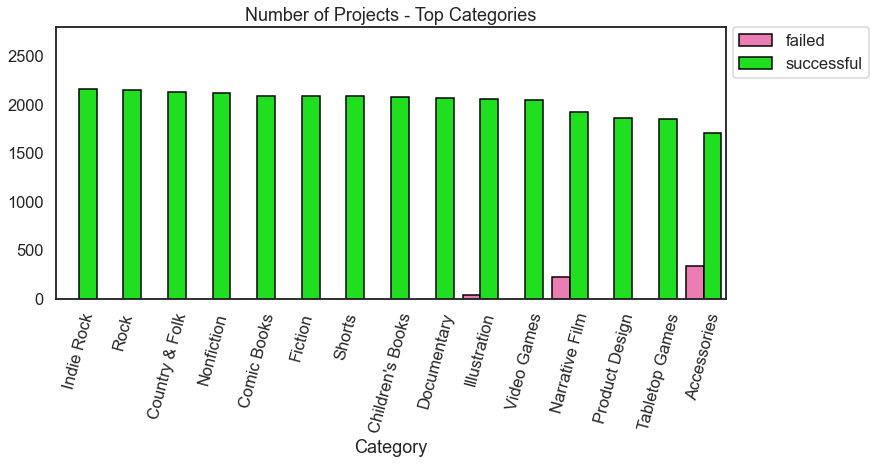

In [18]:
#Top Categories
n = 15
plt.figure(figsize=(12,5))
sns.countplot(
    data = df,
    x="category_name",
    hue="state",
    order=df[df['state']=='successful'].category_name.value_counts().iloc[:n].index,
    palette={"failed": "hotpink", "successful": "lime"},
    edgecolor='black'
).set_title('Number of Projects - Top Categories')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.xlabel("Category")
plt.ylabel("")
plt.ylim(0,2800)
plt.xticks(rotation=75)
plt.savefig('images/Number of Projects - Top Categories');

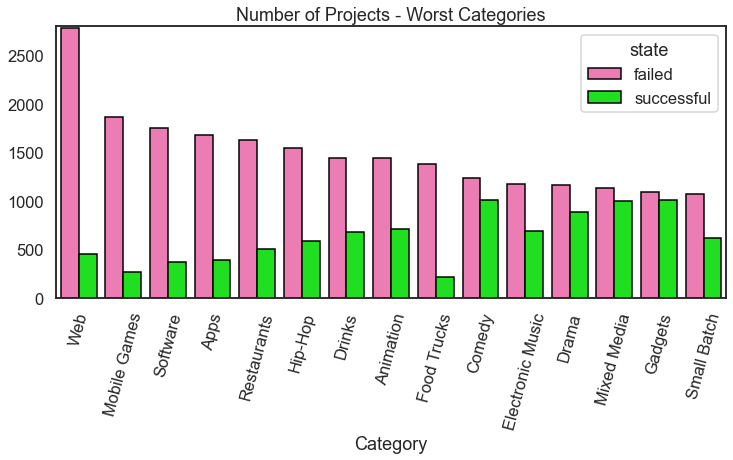

In [19]:
#Worst Categories
n = 15
plt.figure(figsize=(12,5))
sns.countplot(
    data = df,
    x="category_name",
    hue="state",
    order=df[df['state']=='failed'].category_name.value_counts().iloc[:n].index,
    palette={"failed": "hotpink", "successful": "lime"},
    edgecolor='black'
).set_title('Number of Projects - Worst Categories')
plt.xlabel("Category")
plt.ylabel("")
plt.ylim(0,2800)
plt.xticks(rotation=75)
plt.savefig('images/Number of Projects - Worst Categories');

In [20]:
df['ratio_usdpledge_backer'] = df['usd_pledged'] / df['backers_count']
g = df.groupby('category_name').mean().sort_values('ratio_usdpledge_backer',ascending=False)

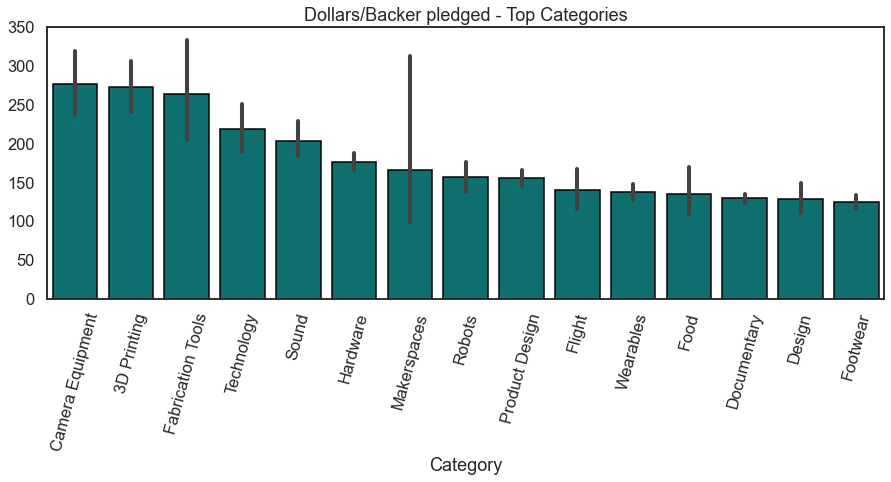

In [21]:
sns.set_style('white')
sns.set_context("talk")
plt.figure(figsize=(15,5))
n=15
g=df.groupby('category_name').mean().sort_values('ratio_usdpledge_backer',ascending=False)

sns.barplot(
    data=df,
    x='category_name',
    y='ratio_usdpledge_backer',
    color="teal",
    edgecolor='black',
    order=g.index[:n]
).set_title('Dollars/Backer pledged - Top Categories')
plt.xlabel("Category")
plt.ylabel("")
plt.ylim(0,350)
plt.xticks(rotation=75)
plt.savefig('images/Dollars-Backer pledged - Top Categories.png');

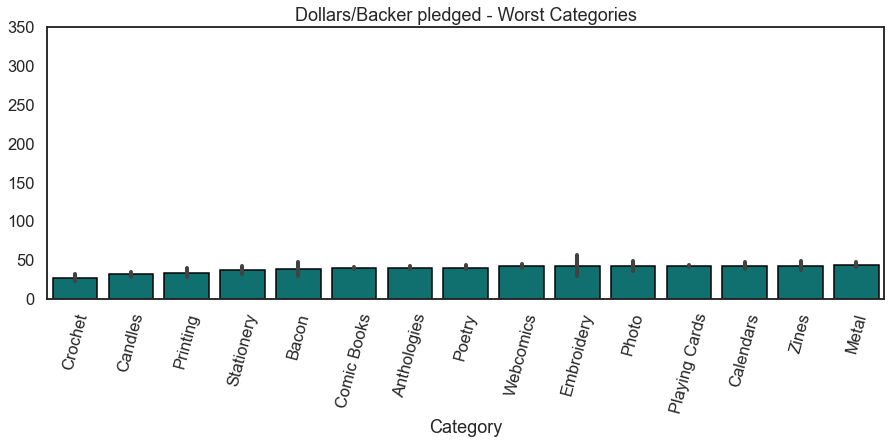

In [22]:
sns.set_style('white')
sns.set_context("talk")
plt.figure(figsize=(15,5))
n=15
g=df.groupby('category_name').mean().sort_values('ratio_usdpledge_backer',ascending=True)

sns.barplot(
    data=df,
    x='category_name',
    y='ratio_usdpledge_backer',
    color="teal",
    edgecolor='black',
    order=g.index[:n]
).set_title('Dollars/Backer pledged - Worst Categories')
plt.xlabel("Category")
plt.ylabel("")
plt.ylim(0,350)
plt.xticks(rotation=75)
plt.savefig('images/Dollars-Backer pledged - Worst Categories.png');

## Length of Project Campaign

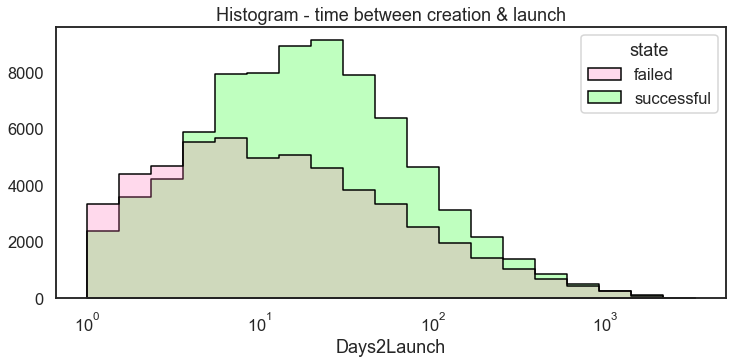

In [23]:
df['delta_create_launch'] = df['launched_at'] - df['created_at']
def toDay(time_delta):
    return round(time_delta/3600/24,2)
df.delta_create_launch=toDay(df.delta_create_launch)
plt.figure(figsize=(12,5))
LogMin, LogMax = np.log10(df['delta_create_launch'].min()+1.),np.log10(df['delta_create_launch'].max())
newBins = np.logspace(LogMin, LogMax,20)
sns.histplot(
    data=df,
    x='delta_create_launch',
    hue='state',
    palette={"failed": "hotpink", "successful": "lime"},
    edgecolor='black',
    bins=newBins,
    element='step'
).set_title('Histogram - time between creation & launch')
plt.xscale('log')
plt.xlabel("Days2Launch")
plt.ylabel("")
plt.savefig('images/Histogram - time between creation & launch.png');

* show pairplot + hue=state
* first observations of pairplots
* heatmap of all features
* findings of heatmap

* drop features:
  - name of features
  - reason why
* we have new features:
  - name
  - reason
* data cleaning in next step

## Prepare the Data

* data cleaning:
  - drop duplicates!
  - ...
* feature engineering
* scaling (stardardization or min-max-scaling)
* log scaling
* feature combination (backers ratio?)
* how to handle outliers?

## Creation of promising models

* bla
* blub

## Fine tuning

* bla
* blub